# Explore OBA star sample from Gaia DR3 Golden Sample paper

This notebook reproduces the analysis of the golden sample of young OBA disk stars in section 3.2 of the paper _Gaia Data Release 3: A Golden Sample of Astrophysical Parameters_ by [Gaia Collaboration, Creevey et al. (2022)]()

First query the Gaia DR3 archive for the data necessary to reproduce the analysis and store in the `../data` folder.

```
select gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error,
gaia.pmdec, gaia.pmdec_error, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, 
gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.g_rp, gaia.bp_g, 
gaia.ag_gspphot, gaia.ebpminrp_gspphot, gaia.teff_gspphot, gaia.logg_gspphot,
aps.teff_esphs, aps.logg_esphs, aps.ag_esphs, aps.ebpminrp_esphs, aps.spectraltype_esphs, oba.vtan_flag
from gaiadr3.gold_sample_oba_stars as oba
join gaiadr3.astrophysical_parameters as aps
using (source_id)
join gaiadr3.gaia_source as gaia
using (source_id)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import healpy as hp
from astropy.table import Table
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
from astropy.visualization import HistEqStretch, ImageNormalize
import astropy.units as u
import astropy.constants as c
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from sklearn.neighbors import KernelDensity
from astroML.plotting.mcmc import convert_to_stdev

from plotstyles import useagab, apply_tufte
from icrstogal import *

from gala.potential.potential.builtin.special import BovyMWPotential2014
from diskkinematicmodel import *

useagab(axislinewidths=2, linewidths=3)

## Kinematic disk model

Create a very simple kinematic model of the disk in which all stars are on circular orbits with speeds $V_\phi(R)$ given by the rotation curve extracted from the selected potential. See [diskkinematicmodel.py](diskkinematicmodel.py). Also define here the limits in total and tangential velocity for separating thin disk, thick disk, and halo populations.

* Thin disk: $v_\mathrm{tot}<50$ km s$^{-1}$, $v_\mathrm{tan}<40$ km s$^{-1}$
* Thick disk: $50\leq v_\mathrm{tot}\leq180$ km s$^{-1}$, $40\leq v_\mathrm{tan}\leq 180$ km s$^{-1}$
* Halo: $v_\mathrm{tot}>180$ km s$^{-1}$, $v_\mathrm{tan}>180$ km s$^{-1}$

In [2]:
Rsun = 8277.0*u.pc
zsun = 20.8*u.pc
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.pc
vsunpeculiar = np.array([11.1, 12.24, 7.25])*u.km/u.s

diskmodel = DiskKinematicModel(BovyMWPotential2014(), sunpos, vsunpeculiar)

vcircsun = diskmodel.get_circular_velocity(sunpos)[0]
print(vcircsun)

vtanthin = 40.0
vtanhalo = 180.0
vtotthin = 50.0
vtothalo = 180.0

plxsnr_min = 10

219.22899730786094 km / s


# Source table meta-data and definition of sub-samples

Read in the data, calculate the value of the tangential velocity, and the galactic coordinates and galactic proper motions. The tangential velocity is:

\begin{equation}
v_\mathrm{tan} = \frac{A_\mathrm{v}}{\varpi}\sqrt{\mu_{\alpha*}^2+\mu_\delta^2}
\end{equation}

In [3]:
obatable = Table.read('../data/OBAGoldenSample.fits', format='fits')
obatable['parallax_over_error'] = obatable['parallax']/obatable['parallax_error']
obatable['vtan'] = (au_km_year_per_sec/obatable['parallax']*np.sqrt(obatable['pmra']**2+obatable['pmdec']**2)).value*u.km/u.s
icrs_coords = ICRS(ra = (obatable['ra'].data*u.deg).to(u.rad),
                   dec = (obatable['dec'].data*u.deg).to(u.rad),
                   distance = (1000/obatable['parallax'].data)*u.pc,
                   pm_ra_cosdec = obatable['pmra'].data*u.mas/u.yr,
                   pm_dec = obatable['pmdec'].data*u.mas/u.yr,
                  radial_velocity = obatable['ra'].value*0.0*u.km/u.s)

galactic_coords, galactocentric_cartesian, galactocentric_cylindrical = transform_to_galactic(icrs_coords, galcendist=Rsun, sunheight=zsun, vcircsun=vcircsun, 
        vsunpec=vsunpeculiar)

obatable['l'] = galactic_coords.l.to(u.deg)
obatable['b'] = galactic_coords.b.to(u.deg)
obatable['pml'] = galactic_coords.pm_l_cosb
obatable['pmb'] = galactic_coords.pm_b

obatable['x_gc'] = galactocentric_cartesian.x
obatable['y_gc'] = galactocentric_cartesian.y
obatable['z_gc'] = galactocentric_cartesian.z

obatable['gmag0_gspphot'] = obatable['phot_g_mean_mag'] - obatable['ag_gspphot']
obatable['gmag0_esphs'] = obatable['phot_g_mean_mag'] - obatable['ag_esphs']
obatable['bp_rp0_gspphot'] = obatable['bp_rp'] - obatable['ebpminrp_gspphot']
obatable['bp_rp0_esphs'] = obatable['bp_rp'] - obatable['ebpminrp_esphs']

obatable.info

<Table length=3023388>
         name          dtype       unit        class      n_bad 
--------------------- ------- ------------- ------------ -------
            source_id   int64                     Column       0
                   ra float64           deg       Column       0
                  dec float64           deg       Column       0
             parallax float64           mas       Column       0
       parallax_error float32           mas       Column       0
                 pmra float64      mas / yr       Column       0
           pmra_error float32      mas / yr       Column       0
                pmdec float64      mas / yr       Column       0
          pmdec_error float32      mas / yr       Column       0
   parallax_pmra_corr float32                     Column       0
  parallax_pmdec_corr float32                     Column       0
      pmra_pmdec_corr float32                     Column       0
      radial_velocity float32        km / s MaskedColumn 2583866
ra

Define some sub-samples (O, B, A stars).

In [4]:
ostars = (obatable['spectraltype_esphs'] == 'O')
bstars = (obatable['spectraltype_esphs'] == 'B')
astars = (obatable['spectraltype_esphs'] == 'A')
num_esp_ostars = obatable['source_id'][ostars].size
num_esp_bstars = obatable['source_id'][bstars].size
num_esp_astars = obatable['source_id'][astars].size
print(f"Number of ESPHS classified O stars: {num_esp_ostars}")
print(f"Number of ESPHS classified B stars: {num_esp_bstars}")
print(f"Number of ESPHS classified A stars: {num_esp_astars}")
print(f"Total ESPHS classified OBA stars: {num_esp_ostars+num_esp_bstars+num_esp_astars}")
print()

rvvalid = np.logical_not(np.isnan(obatable['radial_velocity']))
print(f"Number of OBA stars with RV: {obatable['source_id'][rvvalid].size}")
print(f"Number of ESPHS classified O stars with RV: {obatable['source_id'][ostars & rvvalid].size}")
print(f"Number of ESPHS classified B stars with RV: {obatable['source_id'][bstars & rvvalid].size}")
print(f"Number of ESPHS classified A stars with RV: {obatable['source_id'][astars & rvvalid].size}")
print(f"Total ESPHS classified OBA stars with RV: {obatable['source_id'][(ostars | bstars | astars) & rvvalid].size}")

Number of ESPHS classified O stars: 7903
Number of ESPHS classified B stars: 682199
Number of ESPHS classified A stars: 2056891
Total ESPHS classified OBA stars: 2746993

Number of OBA stars with RV: 439522
Number of ESPHS classified O stars with RV: 1313
Number of ESPHS classified B stars with RV: 99320
Number of ESPHS classified A stars with RV: 283214
Total ESPHS classified OBA stars with RV: 383847


## Calculate the 6D phase space coordinates for the stars with a radial velocity

This refers to 3D galactocentric position and velocities of the stars in both Cartesian and Cylindrical coordinates. This can only be done for stars with radial velocities. From these data also the total velocity with the respect to the local circular velocity (or local standard of rest, LSR) is calculated as:

\begin{equation}
    v_\mathrm{tot,LSR} = \sqrt{v_R^2+v_z^2+(v_\phi-v_\mathrm{LSR})^2}\,,
\end{equation}

where $v_\mathrm{LSR}$ is taken from the disk kinematic model selected above.

In [5]:
oba_rv = obatable[:][rvvalid]
icrs_coords = ICRS(ra = (oba_rv['ra'].data*u.deg).to(u.rad),
                   dec = (oba_rv['dec'].data*u.deg).to(u.rad),
                   distance = (1000/oba_rv['parallax'].data)*u.pc,
                   pm_ra_cosdec = oba_rv['pmra'].data*u.mas/u.yr,
                   pm_dec = oba_rv['pmdec'].data*u.mas/u.yr,
                   radial_velocity = oba_rv['radial_velocity'].data*u.km/u.s)

galactic_coords, galactocentric_cartesian, galactocentric_cylindrical = transform_to_galactic(icrs_coords, galcendist=Rsun, sunheight=zsun, vcircsun=vcircsun, 
        vsunpec=vsunpeculiar)

oba_rv['l'] = galactic_coords.l.to(u.deg)
oba_rv['b'] = galactic_coords.b.to(u.deg)
oba_rv['pml'] = galactic_coords.pm_l_cosb
oba_rv['pmb'] = galactic_coords.pm_b

oba_rv['x_gc'] = galactocentric_cartesian.x
oba_rv['y_gc'] = galactocentric_cartesian.y
oba_rv['z_gc'] = galactocentric_cartesian.z
oba_rv['v_x_gc'] = galactocentric_cartesian.v_x
oba_rv['v_y_gc'] = galactocentric_cartesian.v_y
oba_rv['v_z_gc'] = galactocentric_cartesian.v_z

#Convert Cylindrical into conventional units (km/s for the velocities, making v_phi positive along
#the direction of Galactic rotation).
oba_rv['R_gc'] = galactocentric_cylindrical.rho
phi = galactocentric_cylindrical.phi.to(u.deg)
oba_rv['phi_gc'] = np.where(phi<0*u.deg, phi+360*u.deg, phi.to(u.deg))*u.deg
oba_rv['v_R_gc'] = galactocentric_cylindrical.d_rho.to(u.km/u.s)
# In the literature vphi is calculated for a left-handed coordinate system! 
# This is for the convenience of having postive values of vphi at the position of the sun.
oba_rv['v_phi_gc'] = -(galactocentric_cylindrical.d_phi.to(u.rad/u.yr)/u.rad * galactocentric_cylindrical.rho).to(u.km/u.s)

oba_rv['vtot_lsr'] = np.sqrt(oba_rv['v_R_gc']**2 + (oba_rv['v_phi_gc']-vcircsun.value)**2 + oba_rv['v_z_gc']**2)

ostars_rv = (oba_rv['spectraltype_esphs'] == 'O')
bstars_rv = (oba_rv['spectraltype_esphs'] == 'B')
astars_rv = (oba_rv['spectraltype_esphs'] == 'A')

# Sky distributions

Plot the distributions of the sample of OBA stars on the sky as a basic sanity check. It can be seen how (as expected) the thickness of the distribution of stars in the plane goes up from O to B to A stars. The selection $\varpi/\sigma_\varpi$ gets rid of the Magellanic clouds.

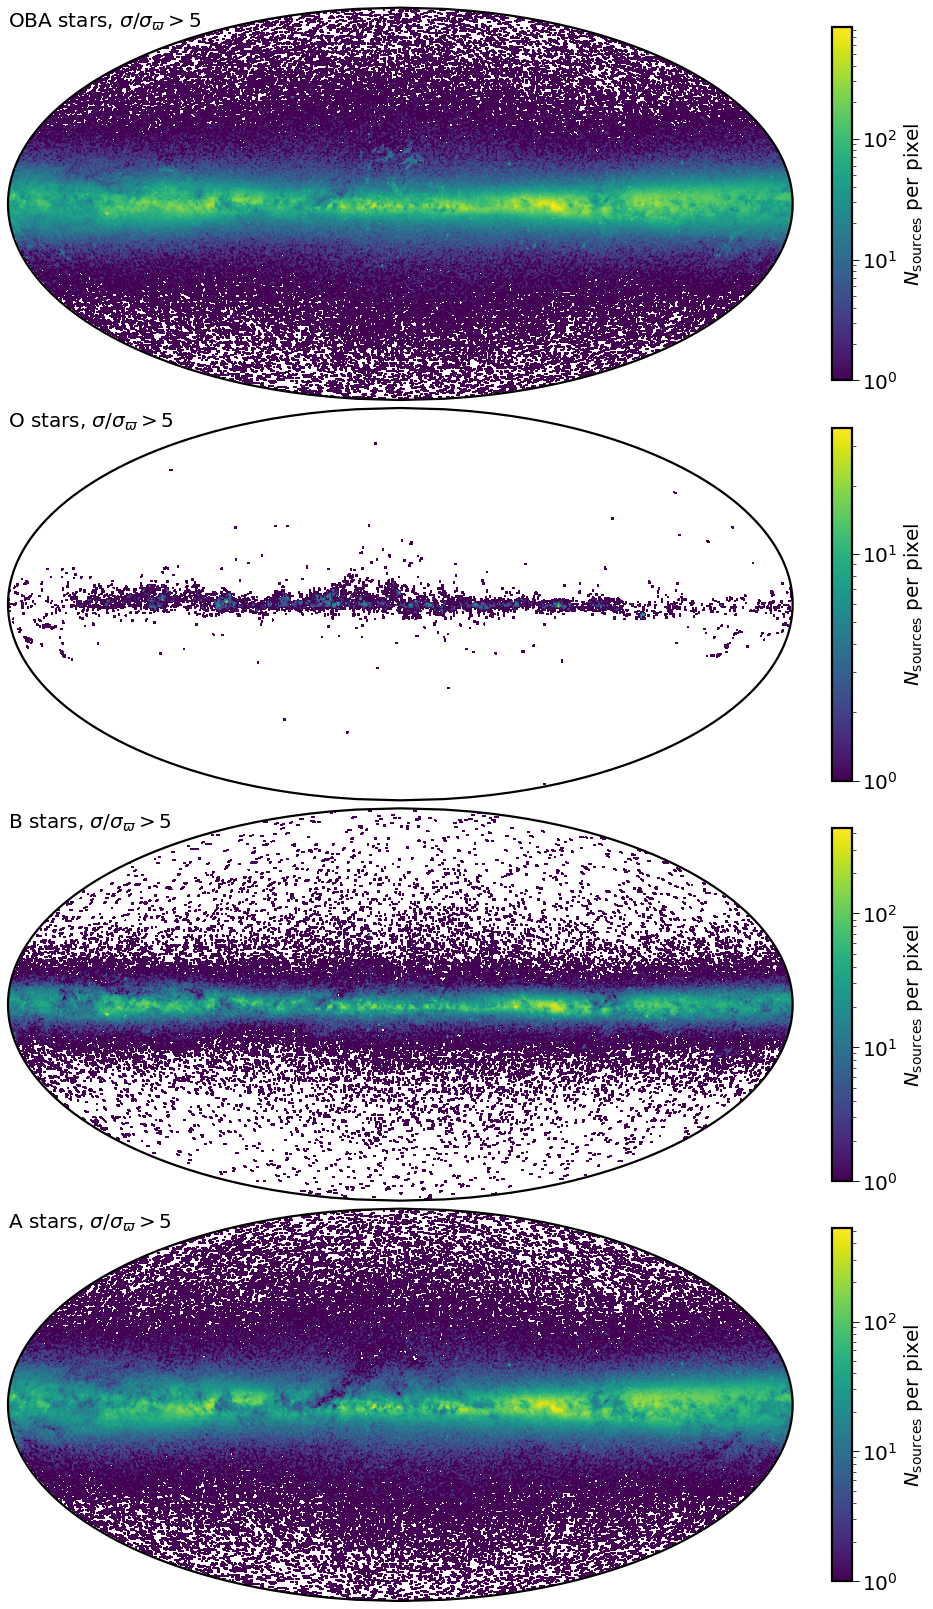

In [6]:
defaultProj = ccrs.PlateCarree()
skyProj = ccrs.Mollweide()

hplevel=7
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpindices = np.arange(npix)

plxsnr_lim = 5
plxfilter = obatable['parallax_over_error']>plxsnr_lim

pixelnums = hp.ang2pix(nside, obatable['ra'][plxfilter], obatable['dec'][plxfilter], lonlat=True)
scounts = np.bincount(pixelnums, minlength=npix)
pixelnums = hp.ang2pix(nside, obatable['ra'][ostars & plxfilter], obatable['dec'][ostars & plxfilter], lonlat=True)
ocounts = np.bincount(pixelnums, minlength=npix)
pixelnums = hp.ang2pix(nside, obatable['ra'][bstars & plxfilter], obatable['dec'][bstars & plxfilter], lonlat=True)
bcounts = np.bincount(pixelnums, minlength=npix)
pixelnums = hp.ang2pix(nside, obatable['ra'][astars & plxfilter], obatable['dec'][astars & plxfilter], lonlat=True)
acounts = np.bincount(pixelnums, minlength=npix)

ctrans = ['C', 'G']
fdpi=80
fw=10
fh=fw/2

_, _, sourcecountmap = hp.newvisufunc.projview(scounts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                            projection_type='cart', return_only_data=True)
_, _, ocountmap = hp.newvisufunc.projview(ocounts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                          projection_type='cart', return_only_data=True)
_, _, bcountmap = hp.newvisufunc.projview(bcounts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                          projection_type='cart', return_only_data=True)
_, _, acountmap = hp.newvisufunc.projview(acounts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                         projection_type='cart', return_only_data=True)

fig=plt.figure(constrained_layout=True, figsize=(fw+3,4*fh), dpi=fdpi, frameon=False)

gs = GridSpec(4, 2, figure=fig, width_ratios=[fw,3])
#gs.tight_layout(fig)

axns = fig.add_subplot(gs[0,0], projection=skyProj)
im_ns = axns.imshow(sourcecountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=scounts.max()))
#axnscans.gridlines()
caxns = inset_axes(axns, "2.5%", "90%", loc='center left', 
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axns.transAxes,
                   borderpad=0)
cbarns = fig.colorbar(im_ns, cax=caxns)
cbarns.set_label(r'$N_\mathrm{sources}$ per pixel')
axns.text(0.0, 0.95, rf'OBA stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axns.transAxes)
#axns.plot([60,60],[-90,90], 'k', transform=defaultProj)
axns.invert_xaxis()

#axo = fig.add_subplot(gs[1,0], projection=skyProj)
#axo.plot(obatable['l'][ostars & plxfilter], obatable['b'][ostars & plxfilter], 'o', alpha=0.5, transform=defaultProj)
#axo.plot([0,0],[-90,90], 'w', transform=defaultProj, zorder=-1)
#axo.text(0.0, 0.95, rf'O stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axo.transAxes)
#axo.invert_xaxis()

axo = fig.add_subplot(gs[1,0], projection=skyProj)
im_ns = axo.imshow(ocountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=ocounts.max()))
#axocans.gridlines()
caxo = inset_axes(axo, "2.5%", "90%", loc='center left', 
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axo.transAxes,
                   borderpad=0)
cbarns = fig.colorbar(im_ns, cax=caxo)
cbarns.set_label(r'$N_\mathrm{sources}$ per pixel')
axo.text(0.0, 0.95, rf'O stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axo.transAxes)
axo.invert_xaxis()

axb = fig.add_subplot(gs[2,0], projection=skyProj)
im_ns = axb.imshow(bcountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=bcounts.max()))
#axbcans.gridlines()
caxb = inset_axes(axb, "2.5%", "90%", loc='center left', 
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axb.transAxes,
                   borderpad=0)
cbarns = fig.colorbar(im_ns, cax=caxb)
cbarns.set_label(r'$N_\mathrm{sources}$ per pixel')
axb.text(0.0, 0.95, rf'B stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axb.transAxes)
axb.invert_xaxis()

axa = fig.add_subplot(gs[3,0], projection=skyProj)
im_ns = axa.imshow(acountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=acounts.max()))
#axacans.gridlines()
caxa = inset_axes(axa, "2.5%", "90%", loc='center left', 
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axa.transAxes,
                   borderpad=0)
cbarns = fig.colorbar(im_ns, cax=caxa)
cbarns.set_label(r'$N_\mathrm{sources}$ per pixel')
axa.text(0.0, 0.95, rf'A stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axa.transAxes)
axa.invert_xaxis()

plt.show()

## Examine kinematics

### Radial velocities

The radial velocity histogram show a trend toward narrower distributions from O to B to A stars. Naively I would expect the opposite. Maybe indicative of increased uncertainties and/or systematic errors for increasing $T_\mathrm{eff}$?

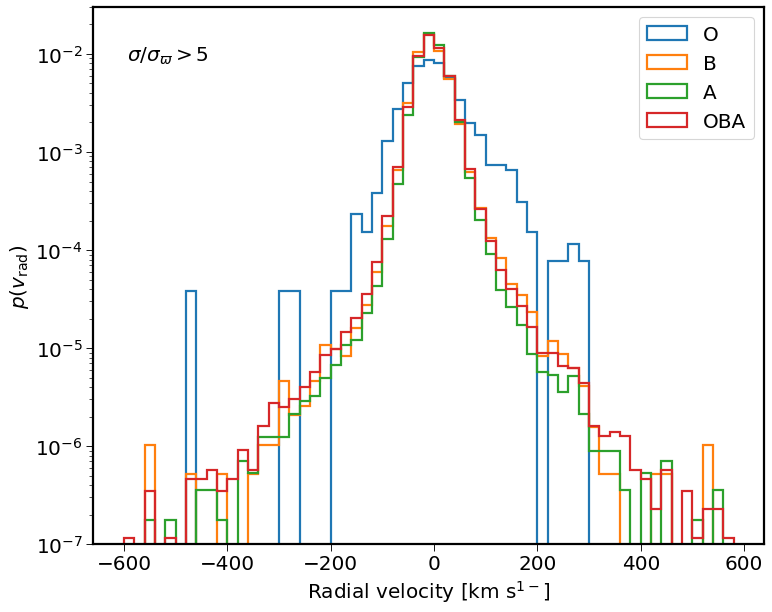

In [7]:
plxsnr_lim = 5
plxfilter = oba_rv['parallax_over_error']>plxsnr_lim

rvbins = np.arange(-600,600,20)

#fig, (axa, axb) = plt.subplots(1, 2, figsize=(20,8), tight_layout=True)
fig, axa = plt.subplots(1, 1, figsize=(10,8), tight_layout=True)

xplot = np.linspace(-600,600,1201)[:, np.newaxis]

axa.hist(oba_rv['radial_velocity'][ostars_rv & plxfilter], bins=rvbins, histtype='step', label='O', density=True, lw=2)
axa.hist(oba_rv['radial_velocity'][bstars_rv & plxfilter], bins=rvbins, histtype='step', label='B', density=True, lw=2)
axa.hist(oba_rv['radial_velocity'][astars_rv & plxfilter], bins=rvbins, histtype='step', label='A', density=True, lw=2)
axa.hist(oba_rv['radial_velocity'][plxfilter], bins=rvbins, histtype='step', label='OBA', density=True, lw=2)
axa.set_yscale('log')
axa.set_ylim(1e-7, 0.03)
axa.set_xlabel(r'Radial velocity [km s$^{1-}$]')
axa.set_ylabel(r'$p(v_\mathrm{rad})$')
axa.text(0.05, 0.9, rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", ha='left', transform=axa.transAxes)
axa.legend()

plt.show()

### Tangential velocities

The histograms of tangential velocties below suggest three populations at less than about 40 km/s, between 40 and 180 km/s and at more than 180 km/s. This is related to the thin disk, thick disk, halo populations and suggests that there is contamination from non-OBA stars.

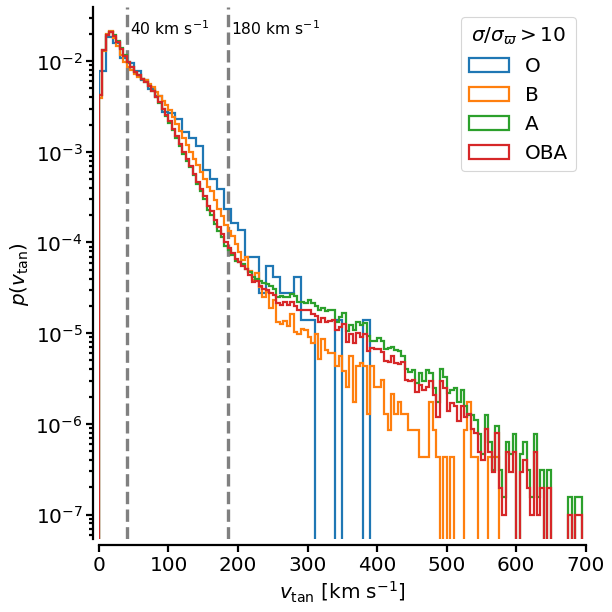

In [8]:
plxsnr_lim = plxsnr_min
plxfilter = obatable['parallax_over_error']>plxsnr_lim

vtanbins5 = np.arange(0,705,5)
vtanbins10 = np.arange(0,710,10)

fig, axa = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)
apply_tufte(axa)

axa.hist(obatable['vtan'][ostars & plxfilter], bins=vtanbins10, histtype='step', label='O', density=True, lw=2)
axa.hist(obatable['vtan'][bstars & plxfilter], bins=vtanbins5, histtype='step', label='B', density=True, lw=2)
axa.hist(obatable['vtan'][astars & plxfilter], bins=vtanbins5, histtype='step', label='A', density=True, lw=2)
axa.hist(obatable['vtan'][plxfilter], bins=vtanbins5, histtype='step', label='OBA', density=True, lw=2)
axa.set_yscale('log')
axa.set_xlim(0,700)
axa.set_xlabel(r'$v_\mathrm{tan}$ [km s$^{-1}$]')
axa.set_ylabel(r'$p(v_\mathrm{tan})$')
axa.axvline(x=40, c='grey', ls='--', zorder=-1)
axa.text(45, 2e-2, r'$40$ km s$^{-1}$', fontsize=14)
axa.axvline(x=185, c='grey', ls='--', zorder=-1)
axa.text(190, 2e-2, r'$180$ km s$^{-1}$', fontsize=14)
axa.legend(title=rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$")

plt.savefig('oba_vtan_hist.png', dpi=150)

plt.show()

#### How the observational HRD is affected by selection on tangential velocity

The observational HRDs below are for the full sample and selected according to the limits pointed out above. Note how in the high tangential motion case (>180 km/s) the population of stars in the CMD is mostly at the location where (blue) horizontal branch are expected (compare to figure 21 in the DR2 observational HRD paper). The analysis of the Toomre diagram below confirms this.

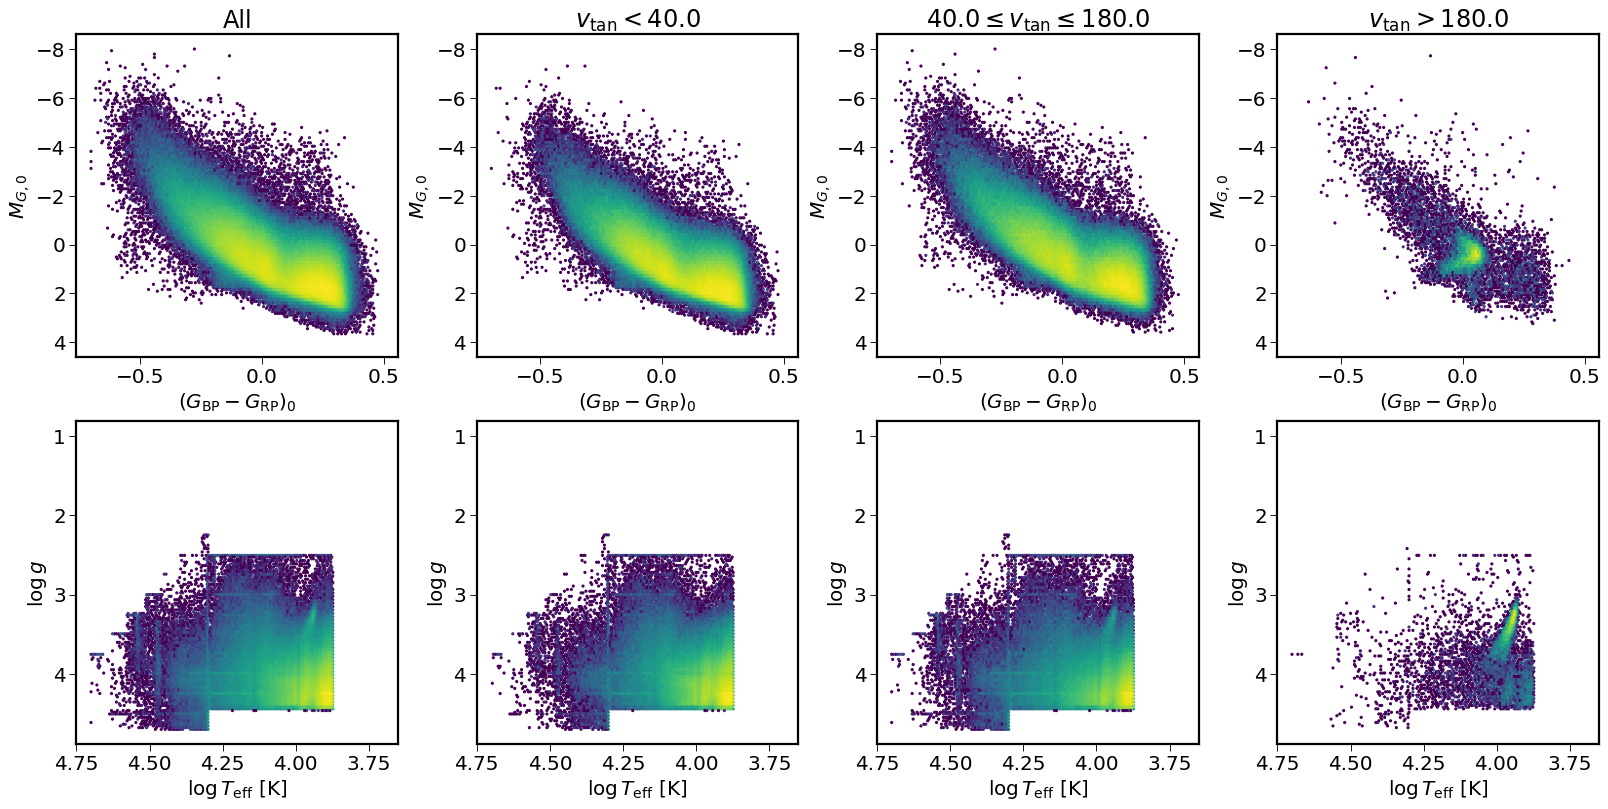

In [9]:
plxsnr_lim = plxsnr_min
plxfilter = obatable['parallax_over_error']>plxsnr_lim
gabs = obatable['phot_g_mean_mag']+5*np.log10(obatable['parallax'])-10.0
gabs_gspphot = obatable['gmag0_gspphot']+5*np.log10(obatable['parallax'])-10.0
gabs_esphs = obatable['gmag0_esphs']+5*np.log10(obatable['parallax'])-10.0

thindisk = obatable['vtan'] < vtanthin
thickdisk = (obatable['vtan'] >= vtanthin) & (obatable['vtan'] <= vtanhalo)
halo = obatable['vtan'] > vtanhalo

fig=plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 4, figure=fig)

filters = [plxfilter, plxfilter & thindisk, plxfilter & thickdisk, plxfilter & halo]
headers = ['All', rf'$v_\mathrm{{tan}}<{vtanthin}$', rf'${vtanthin}\leq v_\mathrm{{tan}}\leq {vtanhalo}$', rf'$v_\mathrm{{tan}}>{vtanhalo}$']

axcmd = []
for i in range(4):
    axcmd.append(fig.add_subplot(gs[0,i]))
for axc, filt, header in zip(axcmd, filters, headers):
    #axc.hexbin(obatable['bp_rp'][filt], gabs[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.5,4.5,-7,10])
    #axc.hexbin(obatable['bp_rp0_gspphot'][filt], gabs_gspphot[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.7,0.5,-8.0,4])
    axc.hexbin(obatable['bp_rp0_esphs'][filt], gabs_esphs[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.7,0.5,-8.0,4])
    axc.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
    axc.set_ylabel(r'$M_{G,0}$')
    axc.set_title(header)
    axc.invert_yaxis()
    
axkiel = []
for i in range(4):
    axkiel.append(fig.add_subplot(gs[1,i]))
for axk, filt, header in zip(axkiel, filters, headers):
    axk.hexbin(np.log10(obatable['teff_esphs'])[filt], obatable['logg_esphs'][filt], gridsize=150, mincnt=1, bins='log', extent=[3.7,4.7,1,4.7])
    axk.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
    axk.set_ylabel(r'$\log g$')
    #axk.set_title(header)
    axk.invert_yaxis()
    axk.invert_xaxis()
                
plt.show()

#### Selection on tangential velocity and sky distribution

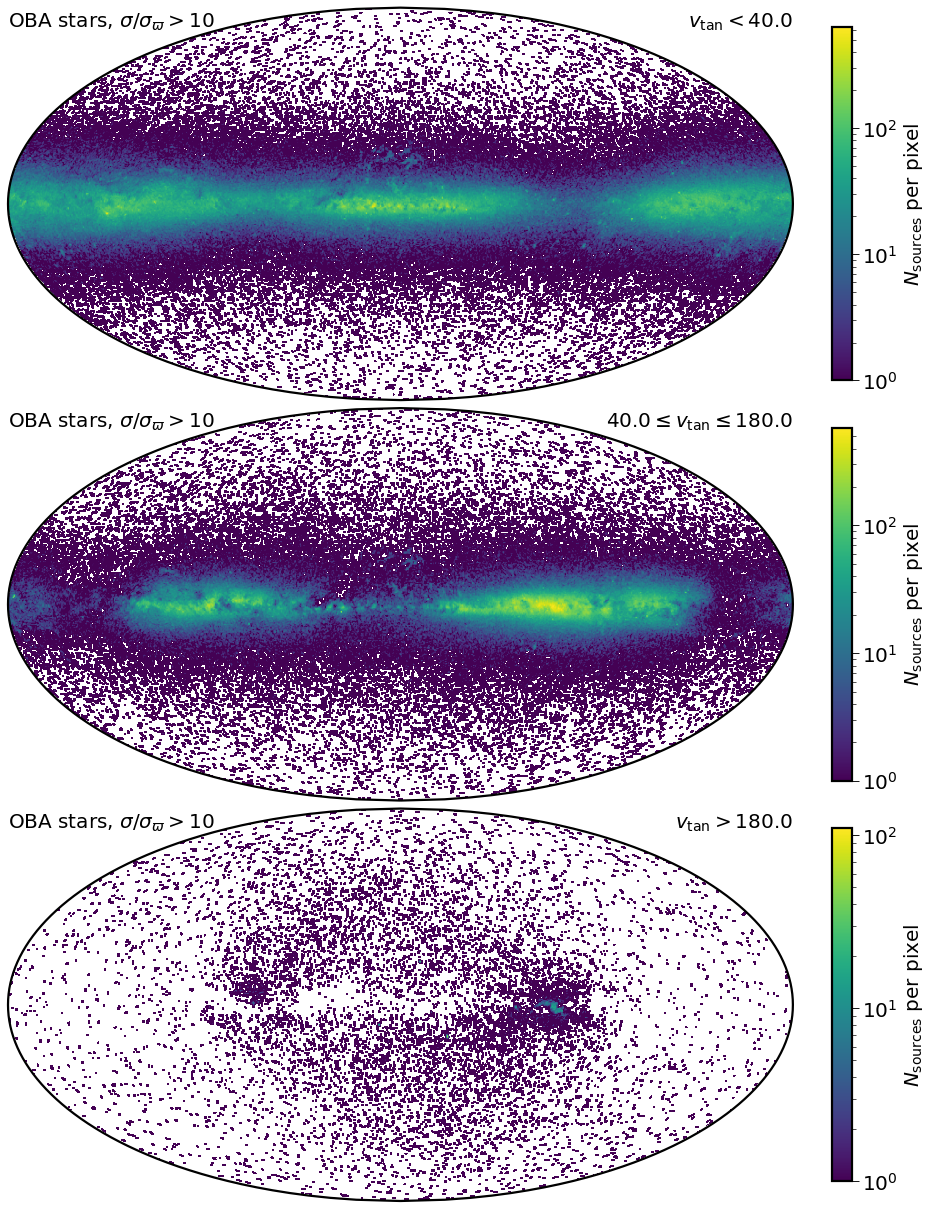

In [10]:
defaultProj = ccrs.PlateCarree()
skyProj = ccrs.Mollweide()

hplevel=7
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpindices = np.arange(npix)

plxsnr_lim = plxsnr_min
plxfilter = obatable['parallax_over_error']>plxsnr_lim

thindisk = obatable['vtan'] < vtanthin
thickdisk = (obatable['vtan'] >= vtanthin) & (obatable['vtan'] <= vtanhalo)
halo = obatable['vtan'] > vtanhalo

pixelnums = hp.ang2pix(nside, obatable['ra'][plxfilter & thindisk], obatable['dec'][plxfilter & thindisk], lonlat=True)
thin_counts = np.bincount(pixelnums, minlength=npix)
pixelnums = hp.ang2pix(nside, obatable['ra'][plxfilter & thickdisk], obatable['dec'][plxfilter & thickdisk], lonlat=True)
thick_counts = np.bincount(pixelnums, minlength=npix)
pixelnums = hp.ang2pix(nside, obatable['ra'][plxfilter & halo], obatable['dec'][plxfilter & halo], lonlat=True)
halo_counts = np.bincount(pixelnums, minlength=npix)

ctrans = ['C', 'G']
fdpi=80
fw=10
fh=fw/2

_,_, thincountmap = hp.newvisufunc.projview(thin_counts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                            projection_type='cart', return_only_data=True)
_,_, thickcountmap = hp.newvisufunc.projview(thick_counts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                            projection_type='cart', return_only_data=True)
_,_, halocountmap = hp.newvisufunc.projview(halo_counts, coord=ctrans, nest=False, title='', unit='', cbar=False, 
                                            projection_type='cart', return_only_data=True)

fig=plt.figure(constrained_layout=True, figsize=(fw+3,3*fh), dpi=fdpi, frameon=False)#, tight_layout={'pad':0.01})

gs = GridSpec(3, 2, figure=fig, width_ratios=[fw,3])

axnthin = fig.add_subplot(gs[0,0], projection=skyProj)
im_nthin = axnthin.imshow(thincountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=thin_counts.max()))
caxnthin = inset_axes(axnthin, "2.5%", "90%", loc='center left', 
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axnthin.transAxes,
                    borderpad=0)
cbarnthin = fig.colorbar(im_nthin, cax=caxnthin)
cbarnthin.set_label(r'$N_\mathrm{sources}$ per pixel')
axnthin.text(0.0, 0.95, rf'OBA stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axnthin.transAxes)
axnthin.text(1.0, 0.95, rf'$v_\mathrm{{tan}}<{vtanthin}$', transform=axnthin.transAxes, ha='right')
axnthin.invert_xaxis()

axnthick = fig.add_subplot(gs[1,0], projection=skyProj)
im_nthick = axnthick.imshow(thickcountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=thick_counts.max()))
caxnthick = inset_axes(axnthick, "2.5%", "90%", loc='center left', 
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axnthick.transAxes,
                    borderpad=0)
cbarnthick = fig.colorbar(im_nthick, cax=caxnthick)
cbarnthick.set_label(r'$N_\mathrm{sources}$ per pixel')
axnthick.text(0.0, 0.95, rf'OBA stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axnthick.transAxes)
axnthick.text(1.0, 0.95, rf'${vtanthin}\leq v _\mathrm{{tan}}\leq{vtanhalo}$', transform=axnthick.transAxes, ha='right')
axnthick.invert_xaxis()

axnhalo = fig.add_subplot(gs[2,0], projection=skyProj)
im_nhalo = axnhalo.imshow(halocountmap, transform=defaultProj, cmap=cm.viridis, origin='lower', norm=LogNorm(vmin=1, vmax=halo_counts.max()))
caxnhalo = inset_axes(axnhalo, "2.5%", "90%", loc='center left', 
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axnhalo.transAxes,
                    borderpad=0)
cbarnhalo = fig.colorbar(im_nhalo, cax=caxnhalo)
cbarnhalo.set_label(r'$N_\mathrm{sources}$ per pixel')
axnhalo.text(0.0, 0.95, rf'OBA stars, $\sigma/\sigma_\varpi>{plxsnr_lim}$', transform=axnhalo.transAxes)
axnhalo.text(1.0, 0.95, rf'$v_\mathrm{{tan}}>{vtanhalo}$', transform=axnhalo.transAxes, ha='right')
axnhalo.invert_xaxis()

plt.show()

### Toomre diagram.

The Toomre diagrams below show $v_\phi$ on the horizontal axis and $\sqrt{v_R^2+v_z^2}$ on the vertical axis. This is a classical diagram for separating stellar populations kinematically and was used for example to isolate the Gaia-Enceldus population. The lines indicate limits on $v_\mathrm{tot,LSR}$, 50 km/s for the thin disk and 180 km/s for the halo (with the thick disk in between). Note that this diagram is now constructed assuming that the rotation curve of the Milky Way is constant, which is okay for local samples but less appropriate for the larger volume covered here. However for a crude analysis this is fine.

Note how especially the A stars show a population with retrograde motions ($v_\phi<0$) and large dispersion on the vertical axis. This is likely merge debris, possibly partly Gaia-Enceladus. The observational HRDs further below show that indeed the population outside $v_\mathrm{tot,LSR}=180$ is dominated by what could be HB stars, which is consistent with an older population.

The Toomre diagram colour coded by $v_\mathrm{tan}$ shows that indeed the tangential velocity can be used to filter out non-disk stars, but it is not perfect as there is population of stars with large $v_\mathrm{tot,LSR}$, yet small $v_\mathrm{tan}$.

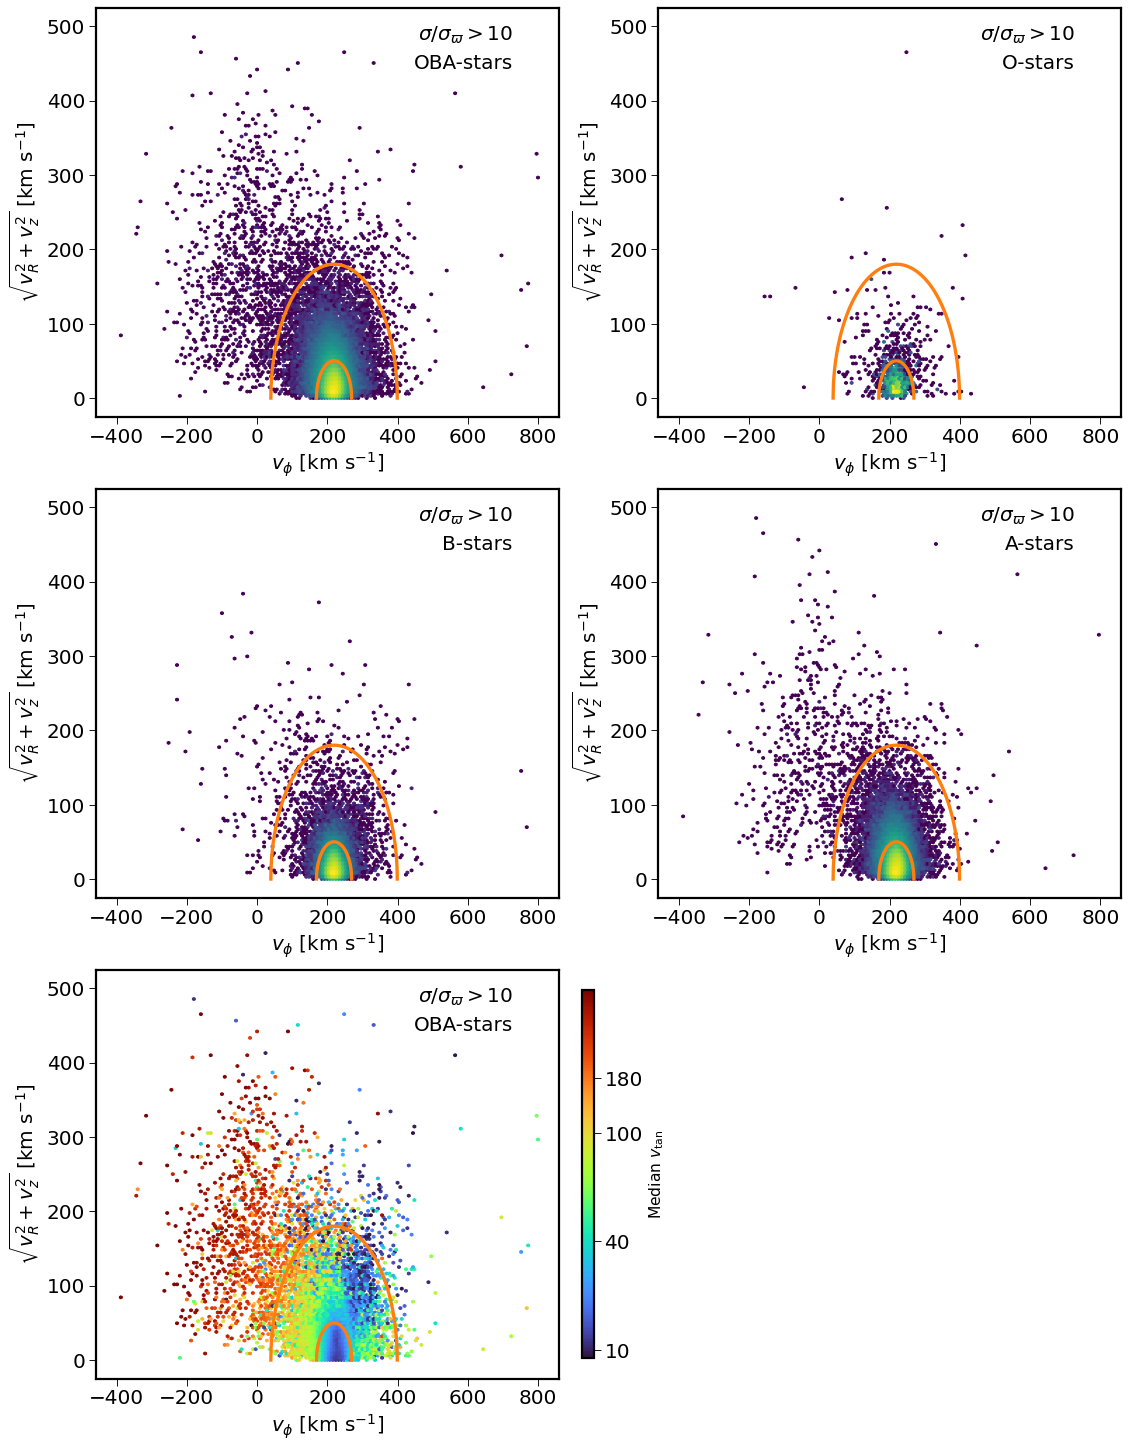

In [11]:
plxsnr_lim = plxsnr_min
plxfilter = oba_rv['parallax_over_error']>plxsnr_lim
vrest = np.sqrt(oba_rv['v_R_gc']**2+oba_rv['v_z_gc']**2)

halo_lim_x = np.linspace(vcircsun.value-vtothalo, vcircsun.value+vtothalo, 1000)
halo_lim_y = np.sqrt(vtothalo**2 - (halo_lim_x-vcircsun.value)**2)
thin_lim_x = np.linspace(vcircsun.value-vtotthin, vcircsun.value+vtotthin, 1000)
thin_lim_y = np.sqrt(vtotthin**2 - (thin_lim_x-vcircsun.value)**2)

fig=plt.figure(constrained_layout=True, figsize=(14,18))

gs = GridSpec(3, 2, figure=fig)

axtd_all = fig.add_subplot(gs[0,0])
axtd_all.hexbin(oba_rv['v_phi_gc'][plxfilter], vrest[plxfilter], mincnt=1, gridsize=150, bins='log', extent=[-400,800,0,500])
axtd_all.set_xlabel(r'$v_\phi$ [km s$^{-1}$]')
axtd_all.set_ylabel(r'$\sqrt{v_R^2+v_z^2}$ [km s$^{-1}$]')

axtd_o = fig.add_subplot(gs[0,1])
axtd_o.hexbin(oba_rv['v_phi_gc'][ostars_rv & plxfilter], vrest[ostars_rv & plxfilter], gridsize=150, bins='log', extent=[-400,800,0,500])

axtd_b = fig.add_subplot(gs[1,0])
axtd_b.hexbin(oba_rv['v_phi_gc'][bstars_rv & plxfilter], vrest[bstars_rv & plxfilter], mincnt=1, gridsize=150, bins='log', extent=[-400,800,0,500])

axtd_a = fig.add_subplot(gs[1,1])
axtd_a.hexbin(oba_rv['v_phi_gc'][astars_rv & plxfilter], vrest[astars_rv & plxfilter], mincnt=1, gridsize=150, bins='log', extent=[-400,800,0,500])

axtd_all_vtan = fig.add_subplot(gs[2,0])
im_tdvtan = axtd_all_vtan.hexbin(oba_rv['v_phi_gc'][plxfilter], vrest[plxfilter], gridsize=150, mincnt=0, 
                              C=oba_rv['vtan'][plxfilter], reduce_C_function=np.median, extent=[-400,800,0,500])
axtd_all_vtan.clear()
imnorm = ImageNormalize(im_tdvtan.get_array(), stretch=HistEqStretch(im_tdvtan.get_array()))
im_tdvtan = axtd_all_vtan.hexbin(oba_rv['v_phi_gc'][plxfilter], vrest[plxfilter], gridsize=150, mincnt=0, 
                              C=oba_rv['vtan'][plxfilter], reduce_C_function=np.median, norm=imnorm, cmap='turbo', extent=[-400,800,0,500])
cax_vtan = inset_axes(axtd_all_vtan, "2.5%", "90%", loc='center left', 
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=axtd_all_vtan.transAxes,
                  borderpad=0)
cbar_vtan = fig.colorbar(im_tdvtan, cax=cax_vtan, ticks=[10, vtanthin, 100, vtanhalo])
cbar_vtan.set_label(r'Median $v_\mathrm{tan}$', fontsize=14)

for ax, sample in zip([axtd_all, axtd_o, axtd_b, axtd_a, axtd_all_vtan], ['OBA-stars', 'O-stars', 'B-stars', 'A-stars', 'OBA-stars']):
    ax.plot(halo_lim_x, halo_lim_y, '-', c='C1', lw=3)
    ax.plot(thin_lim_x, thin_lim_y, '-', c='C1', lw=3)
    ax.set_xlabel(r'$v_\phi$ [km s$^{-1}$]')
    ax.set_ylabel(r'$\sqrt{v_R^2+v_z^2}$ [km s$^{-1}$]')
    ax.text(0.9, 0.92,  rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", ha='right', transform=ax.transAxes)
    ax.text(0.9, 0.85,  sample, ha='right', transform=ax.transAxes)

plt.show()

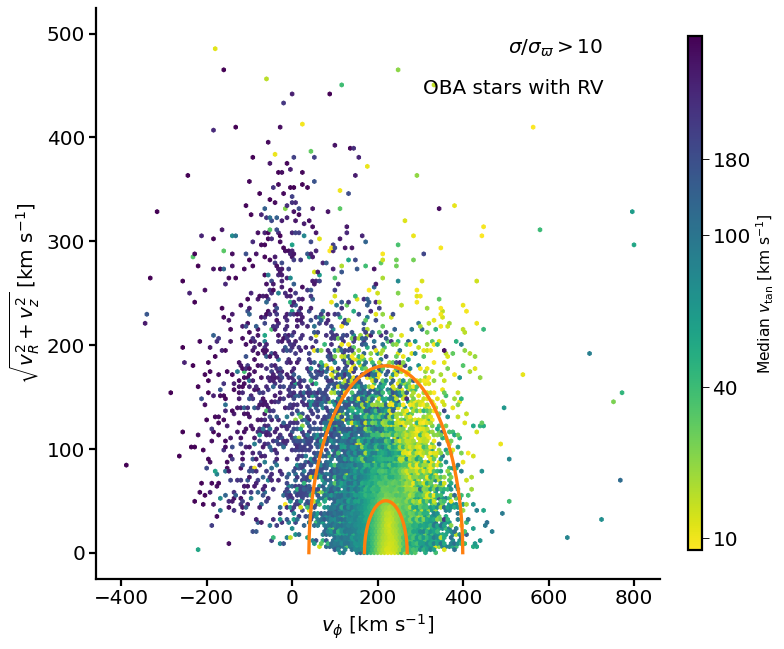

In [12]:
plxsnr_lim = plxsnr_min
plxfilter = oba_rv['parallax_over_error']>plxsnr_lim

fig = plt.figure(figsize=(10,8), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[8,2])
axtoomre = fig.add_subplot(gs[0,0])
apply_tufte(axtoomre)

imtoomre = axtoomre.hexbin(oba_rv['v_phi_gc'][plxfilter], vrest[plxfilter], gridsize=150, mincnt=0, 
                              C=oba_rv['vtan'][plxfilter], reduce_C_function=np.median, extent=[-400,800,0,500])
axtoomre.clear()
imnorm = ImageNormalize(imtoomre.get_array(), stretch=HistEqStretch(imtoomre.get_array()))
imtoomre = axtoomre.hexbin(oba_rv['v_phi_gc'][plxfilter], vrest[plxfilter], gridsize=150, mincnt=0, 
                              C=oba_rv['vtan'][plxfilter], reduce_C_function=np.median, norm=imnorm, cmap='viridis_r', extent=[-400,800,0,500])
cax_vtan = inset_axes(axtoomre, "2.5%", "90%", loc='center left', 
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=axtoomre.transAxes,
                  borderpad=0)
cbar_vtan = fig.colorbar(imtoomre, cax=cax_vtan, ticks=[10, vtanthin, 100, vtanhalo])
cbar_vtan.set_label(r'Median $v_\mathrm{tan}$ [km s$^{-1}$]', fontsize=14)
axtoomre.plot(halo_lim_x, halo_lim_y, '-', c='C1', lw=3)
axtoomre.plot(thin_lim_x, thin_lim_y, '-', c='C1', lw=3)
axtoomre.set_xlabel(r'$v_\phi$ [km s$^{-1}$]')
axtoomre.set_ylabel(r'$\sqrt{v_R^2+v_z^2}$ [km s$^{-1}$]')
axtoomre.text(0.9, 0.92,  rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", ha='right', transform=axtoomre.transAxes)
axtoomre.text(0.9, 0.85,  'OBA stars with RV', ha='right', transform=axtoomre.transAxes)

plt.savefig('oba_toomre.png', dpi=150)

plt.show()

#### How the observational HRD is affected by selection on total velocity

The observational HRDs below are for the sample of OBA stars with radial velocity and confirm that the population at large $v_\mathrm{tot,LSR}$ corresponds to HB stars.

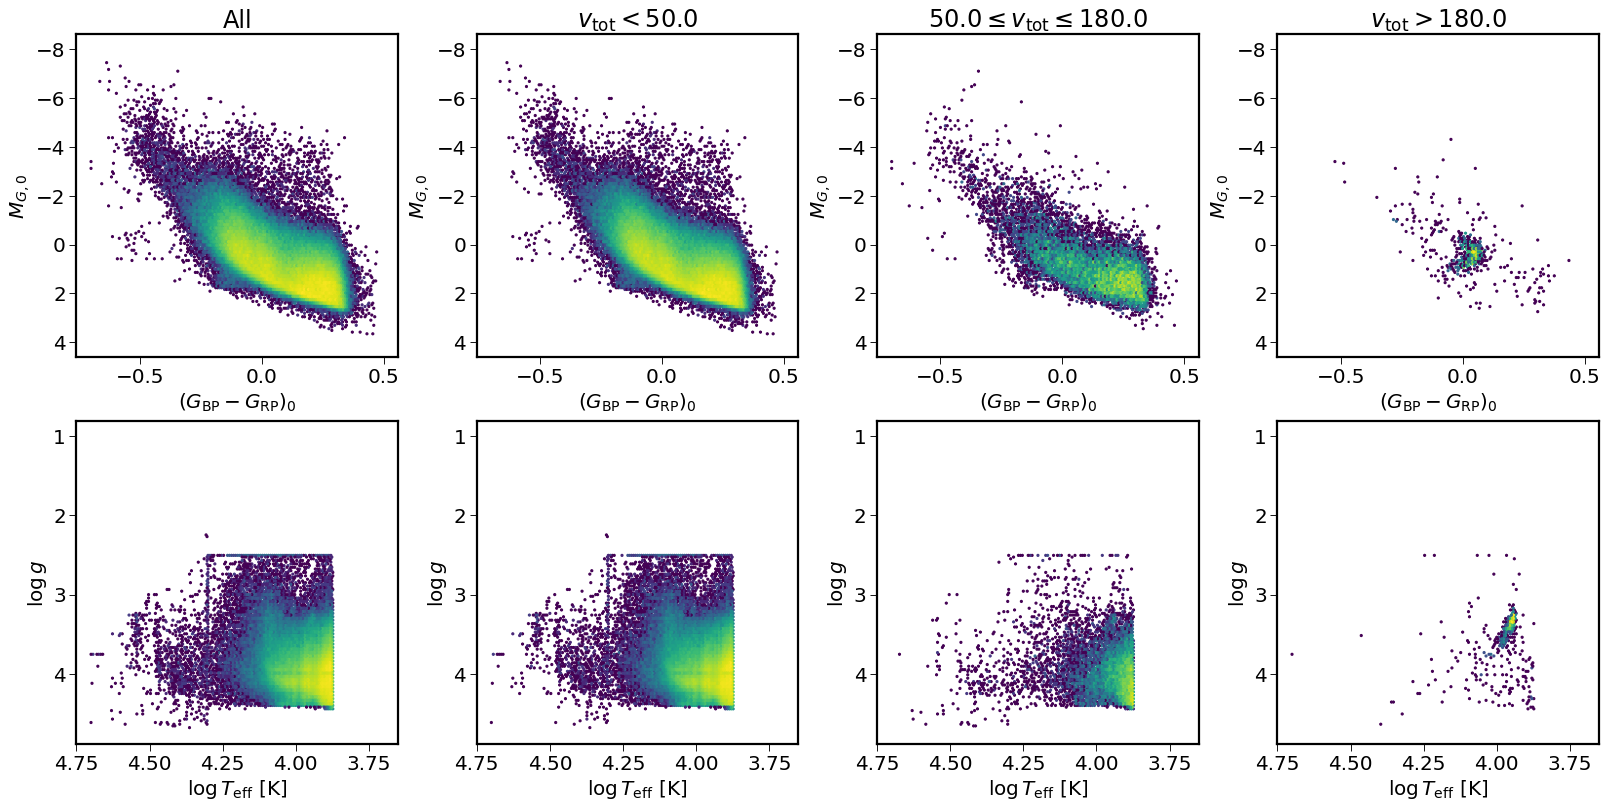

In [13]:
plxsnr_lim = plxsnr_min
plxfilter = oba_rv['parallax_over_error']>plxsnr_lim
gabs_rv = oba_rv['phot_g_mean_mag']+5*np.log10(oba_rv['parallax'])-10.0
gabs0_gspphot_rv = oba_rv['gmag0_gspphot']+5*np.log10(oba_rv['parallax'])-10.0
gabs0_esphs_rv = oba_rv['gmag0_esphs']+5*np.log10(oba_rv['parallax'])-10.0

thindisk = oba_rv['vtot_lsr'] < vtotthin
thickdisk = (oba_rv['vtot_lsr'] >= vtotthin) & (oba_rv['vtot_lsr'] <= vtothalo)
halo = oba_rv['vtot_lsr'] > vtothalo

fig=plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 4, figure=fig)

filters = [plxfilter, plxfilter & thindisk, plxfilter & thickdisk, plxfilter & halo]
headers = ['All', rf'$v_\mathrm{{tot}}<{vtotthin}$', rf'${vtotthin}\leq v_\mathrm{{tot}}\leq {vtothalo}$', rf'$v_\mathrm{{tot}}>{vtothalo}$']

axcmd = []
for i in range(4):
    axcmd.append(fig.add_subplot(gs[0,i]))
for axc, filt, header in zip(axcmd, filters, headers):
    #axc.hexbin(oba_rv['bp_rp'][filt], gabs_rv[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.25,4.25,-7,10])
    #axc.hexbin(oba_rv['bp_rp0_gspphot'][filt], gabs0_gspphot_rv[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.7,0.5,-8.0,4])
    axc.hexbin(oba_rv['bp_rp0_esphs'][filt], gabs0_esphs_rv[filt], gridsize=150, mincnt=1, bins='log', extent=[-0.7,0.5,-8.0,4])
    axc.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
    axc.set_ylabel(r'$M_{G,0}$')
    axc.set_title(header)
    axc.invert_yaxis()

axkiel = []
for i in range(4):
    axkiel.append(fig.add_subplot(gs[1,i]))
for axk, filt, header in zip(axkiel, filters, headers):
    axk.hexbin(np.log10(oba_rv['teff_esphs'])[filt], oba_rv['logg_esphs'][filt], gridsize=150, mincnt=1, bins='log', extent=[3.7,4.7,1,4.7])
    axk.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
    axk.set_ylabel(r'$\log g$')
    #axk.set_title(header)
    axk.invert_yaxis()
    axk.invert_xaxis()
                
plt.show()

### Colour magnitude diagrams with full sample and the presumable blue horizontal branch stars

First calculate a kernel density estimate of the distribution of the full sample of stars in the CMD diagram.

2026994
0.001603675102210651 1.0


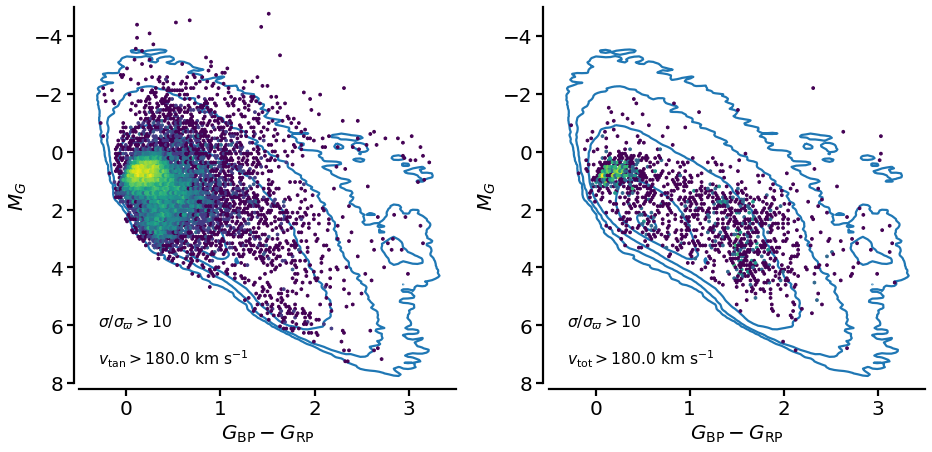

In [14]:
plxsnr_lim = plxsnr_min
plxfilter_rv = oba_rv['parallax_over_error']>plxsnr_lim
gabs_rv = oba_rv['phot_g_mean_mag']+5*np.log10(oba_rv['parallax'])-10.0
halo_rv = oba_rv['vtot_lsr'] > vtothalo

plxfilter = obatable['parallax_over_error']>plxsnr_lim
gabs = obatable['phot_g_mean_mag']+5*np.log10(obatable['parallax'])-10.0
halo = obatable['vtan'] > vtanhalo

print(obatable['bp_rp'][plxfilter].size)

grid_extent = [-0.5, 3.5, -5, 8]
nxgr = int((grid_extent[1]-grid_extent[0])*20)
nygr = int((grid_extent[3]-grid_extent[2])*20)

cmd_data = np.vstack([obatable['bp_rp'][plxfilter], gabs[plxfilter]]).T
cgrid = np.linspace(grid_extent[0], grid_extent[1], nxgr)
mgrid = np.linspace(grid_extent[2], grid_extent[3], nygr)
cc, mm = np.meshgrid(cgrid, mgrid)
ccmm = np.vstack([cc.ravel(), mm.ravel()]).T
kde = KernelDensity(bandwidth=0.1, kernel='epanechnikov')
kde.fit(cmd_data)
ln_density = kde.score_samples(ccmm)
ln_density = ln_density.reshape(cc.shape)
cum_stdev = convert_to_stdev(ln_density)
print(cum_stdev.min(), cum_stdev.max())

#slevels = erf(np.array([0.1,0.5,1])/np.sqrt(2))

fig, (axcmd_comb_vtan, axcmd_comb_vtot) = plt.subplots(1, 2, figsize=(12,6), tight_layout=True)
apply_tufte(axcmd_comb_vtan)
apply_tufte(axcmd_comb_vtot)

axcmd_comb_vtan.contour(cgrid, mgrid, cum_stdev, levels=[0.05, 0.50, 0.95, 0.99, 0.998], linewidths=[2], colors=['C0'], zorder=-1)
axcmd_comb_vtan.hexbin(obatable['bp_rp'][plxfilter & halo], gabs[plxfilter & halo], gridsize=150, bins='log', mincnt=1, extent=grid_extent)
axcmd_comb_vtan.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axcmd_comb_vtan.set_ylabel(r'$M_G$')
axcmd_comb_vtan.set_xlim(grid_extent[0], grid_extent[1])
axcmd_comb_vtan.set_ylim(grid_extent[2], grid_extent[3])
axcmd_comb_vtan.invert_yaxis()
axcmd_comb_vtan.text(0.05, 0.15, rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", transform=axcmd_comb_vtan.transAxes, fontsize=14)
axcmd_comb_vtan.text(0.05, 0.05, rf'$v_\mathrm{{tan}}>{vtanhalo}$ km s$^{{-1}}$', transform=axcmd_comb_vtan.transAxes, fontsize=14)

axcmd_comb_vtot.contour(cgrid, mgrid, cum_stdev, levels=[0.05, 0.50, 0.95, 0.99, 0.998], linewidths=[2], colors=['C0'], zorder=-1)
axcmd_comb_vtot.hexbin(oba_rv['bp_rp'][plxfilter_rv & halo_rv], gabs_rv[plxfilter_rv & halo_rv], gridsize=150, bins='log', mincnt=1, extent=grid_extent)
axcmd_comb_vtot.set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axcmd_comb_vtot.set_ylabel(r'$M_G$')
axcmd_comb_vtot.set_xlim(grid_extent[0], grid_extent[1])
axcmd_comb_vtot.set_ylim(grid_extent[2], grid_extent[3])
axcmd_comb_vtot.invert_yaxis()
axcmd_comb_vtot.text(0.05, 0.15, rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", transform=axcmd_comb_vtot.transAxes, fontsize=14)
axcmd_comb_vtot.text(0.05, 0.05, rf'$v_\mathrm{{tot}}>{vtothalo}$ km s$^{{-1}}$', transform=axcmd_comb_vtot.transAxes, fontsize=14)

plt.savefig('oba_cmd_v_gt_180.png', dpi=150)

plt.show()

### Extinction-corrected colour magnitude and Kiel diagram with full sample and the presumable blue horizontal branch stars

First calculate a kernel density estimate of the distribution of the full sample of stars in the CMD and Kiel diagrams.

Number of stars in full sample above plx snr limit: 2026994
0.0037659989472455134 1.0
0.03208471849624558 1.0


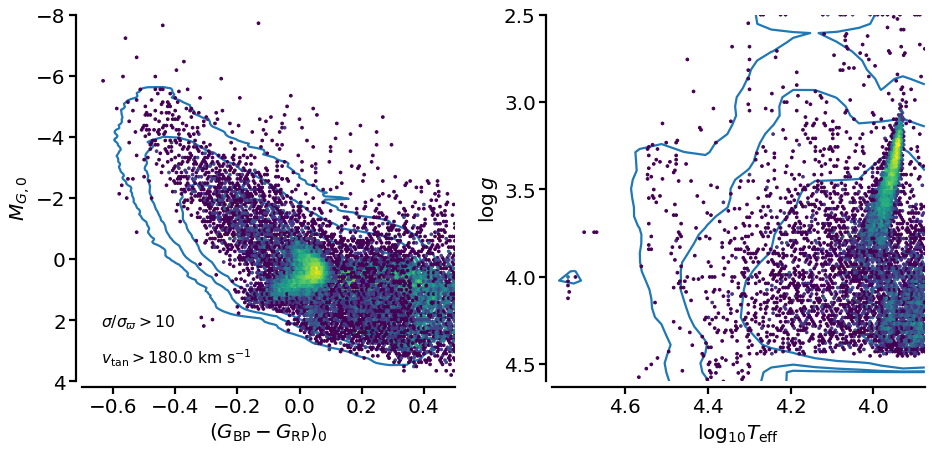

In [15]:
plxsnr_lim = plxsnr_min

plxfilter = obatable['parallax_over_error']>plxsnr_lim
gabs = obatable['phot_g_mean_mag']+5*np.log10(obatable['parallax'])-10.0
gabs_esphs = (obatable['gmag0_esphs']+5*np.log10(obatable['parallax'])-10.0).filled(np.nan)
bpminrp0_esphs = obatable['bp_rp0_esphs'].filled(np.nan)
valid_phot = np.logical_not(np.isnan(gabs_esphs) | np.isnan(bpminrp0_esphs))
halo = obatable['vtan'] > vtanhalo

print(f"Number of stars in full sample above plx snr limit: {obatable['bp_rp'][plxfilter].size}")

#grid_extent_cmd = [-0.5, 3.5, -5.0, 8.0]
grid_extent_cmd = [-0.7, 0.5, -8.0, 4.0]
nxgr = int((grid_extent_cmd[1]-grid_extent_cmd[0])*20)
nygr = int((grid_extent_cmd[3]-grid_extent_cmd[2])*20)

#cmd_data = np.vstack([obatable['bp_rp'][plxfilter], gabs[plxfilter]]).T
cmd_data = np.vstack([bpminrp0_esphs[plxfilter & valid_phot], gabs_esphs[plxfilter & valid_phot]]).T
cgrid = np.linspace(grid_extent_cmd[0], grid_extent_cmd[1], nxgr)
mgrid = np.linspace(grid_extent_cmd[2], grid_extent_cmd[3], nygr)
cc, mm = np.meshgrid(cgrid, mgrid)
ccmm = np.vstack([cc.ravel(), mm.ravel()]).T
kde = KernelDensity(bandwidth=0.1, kernel='epanechnikov')
kde.fit(cmd_data)
ln_density_cmd = kde.score_samples(ccmm)
ln_density_cmd = ln_density_cmd.reshape(cc.shape)
cum_stdev_cmd = convert_to_stdev(ln_density_cmd)
print(cum_stdev_cmd.min(), cum_stdev_cmd.max())

grid_extent_kiel = [np.log10(7500), np.log10(60000), 2.5, 4.6]
nxgr = int((grid_extent_kiel[1]-grid_extent_kiel[0])*20)
nygr = int((grid_extent_kiel[3]-grid_extent_kiel[2])*20)

kiel_data = np.vstack([np.log10(obatable['teff_esphs'][plxfilter]).compressed(), obatable['logg_esphs'][plxfilter].compressed()]).T
tgrid = np.linspace(grid_extent_kiel[0], grid_extent_kiel[1], nxgr)
ggrid = np.linspace(grid_extent_kiel[2], grid_extent_kiel[3], nygr)
tt, gg = np.meshgrid(tgrid, ggrid)
ttgg = np.vstack([tt.ravel(), gg.ravel()]).T
kde.fit(kiel_data)
ln_density_kiel = kde.score_samples(ttgg)
ln_density_kiel = ln_density_kiel.reshape(tt.shape)
cum_stdev_kiel = convert_to_stdev(ln_density_kiel)
print(cum_stdev_kiel.min(), cum_stdev_kiel.max())

#slevels = erf(np.array([0.1,0.5,1])/np.sqrt(2))

fig, (axcmd_comb, axkiel_comb) = plt.subplots(1, 2, figsize=(12,6), tight_layout=True)
apply_tufte(axcmd_comb)
apply_tufte(axkiel_comb)

axcmd_comb.contour(cgrid, mgrid, cum_stdev_cmd, levels=[0.05, 0.50, 0.95, 0.99, 0.998], linewidths=[2], colors=['C0'], zorder=-1)
axcmd_comb.hexbin(obatable['bp_rp'][plxfilter & halo], gabs[plxfilter & halo], gridsize=150, bins='log', mincnt=1, extent=grid_extent_cmd)
axcmd_comb.hexbin(bpminrp0_esphs[plxfilter & halo & valid_phot], gabs_esphs[plxfilter & halo & valid_phot], gridsize=150, bins='log', mincnt=1, extent=grid_extent_cmd)
#axcmd_comb.hexbin(bpminrp0_esphs[plxfilter & halo & valid_phot], gabs_esphs[plxfilter & halo & valid_phot], gridsize=150, bins='log', mincnt=0, extent=grid_extent_cmd,
#                 reduce_C_function=np.median, C=obatable['z_gc'][plxfilter & halo & valid_phot])
axcmd_comb.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
axcmd_comb.set_ylabel(r'$M_{G,0}$')
axcmd_comb.set_xlim(grid_extent_cmd[0], grid_extent_cmd[1])
axcmd_comb.set_ylim(grid_extent_cmd[2], grid_extent_cmd[3])
axcmd_comb.invert_yaxis()
axcmd_comb.text(0.05, 0.15, rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", transform=axcmd_comb.transAxes, fontsize=14)
axcmd_comb.text(0.05, 0.05, rf'$v_\mathrm{{tan}}>{vtanhalo}$ km s$^{{-1}}$', transform=axcmd_comb.transAxes, fontsize=14)
#axcmd_comb.plot([0.05],[0.5], 'o')

axkiel_comb.contour(tgrid, ggrid, cum_stdev_kiel, levels=[0.05, 0.50, 0.95, 0.99, 0.998], linewidths=[2], colors=['C0'], zorder=-1)
axkiel_comb.hexbin(np.log10(obatable['teff_esphs'][plxfilter & halo]), obatable['logg_esphs'][plxfilter & halo],  
                   gridsize=150, bins='log', mincnt=1, extent=grid_extent_kiel)
#axkiel_comb.hexbin(np.log10(obatable['teff_esphs'][plxfilter & halo]), obatable['logg_esphs'][plxfilter & halo],  
#                   gridsize=150, bins='log', mincnt=0, extent=grid_extent_kiel, reduce_C_function=np.median, C=obatable['z_gc'][plxfilter & halo])
axkiel_comb.set_xlabel(r'$\log_{10}T_\mathrm{eff}$')
axkiel_comb.set_ylabel(r'$\log g$')
axkiel_comb.set_xlim(grid_extent_kiel[0], grid_extent_kiel[1])
axkiel_comb.set_ylim(grid_extent_kiel[2], grid_extent_kiel[3])
axkiel_comb.invert_yaxis()
axkiel_comb.invert_xaxis()
axkiel_comb.set_yticks([2.5, 3, 3.5, 4, 4.5])
#axkiel_comb.text(0.05, 0.95, rf"$\sigma/\sigma_\varpi>{plxsnr_lim}$", transform=axkiel_comb.transAxes, fontsize=14)
#axkiel_comb.text(0.05, 0.85, rf'$v_\mathrm{{tan}}>{vtanhalo}$ km s$^{{-1}}$', transform=axkiel_comb.transAxes, fontsize=14)

plt.savefig('oba_cmdkiel_vtan_gt_180.png', dpi=150)

plt.show()

## Proper motions vs galactic coordinates

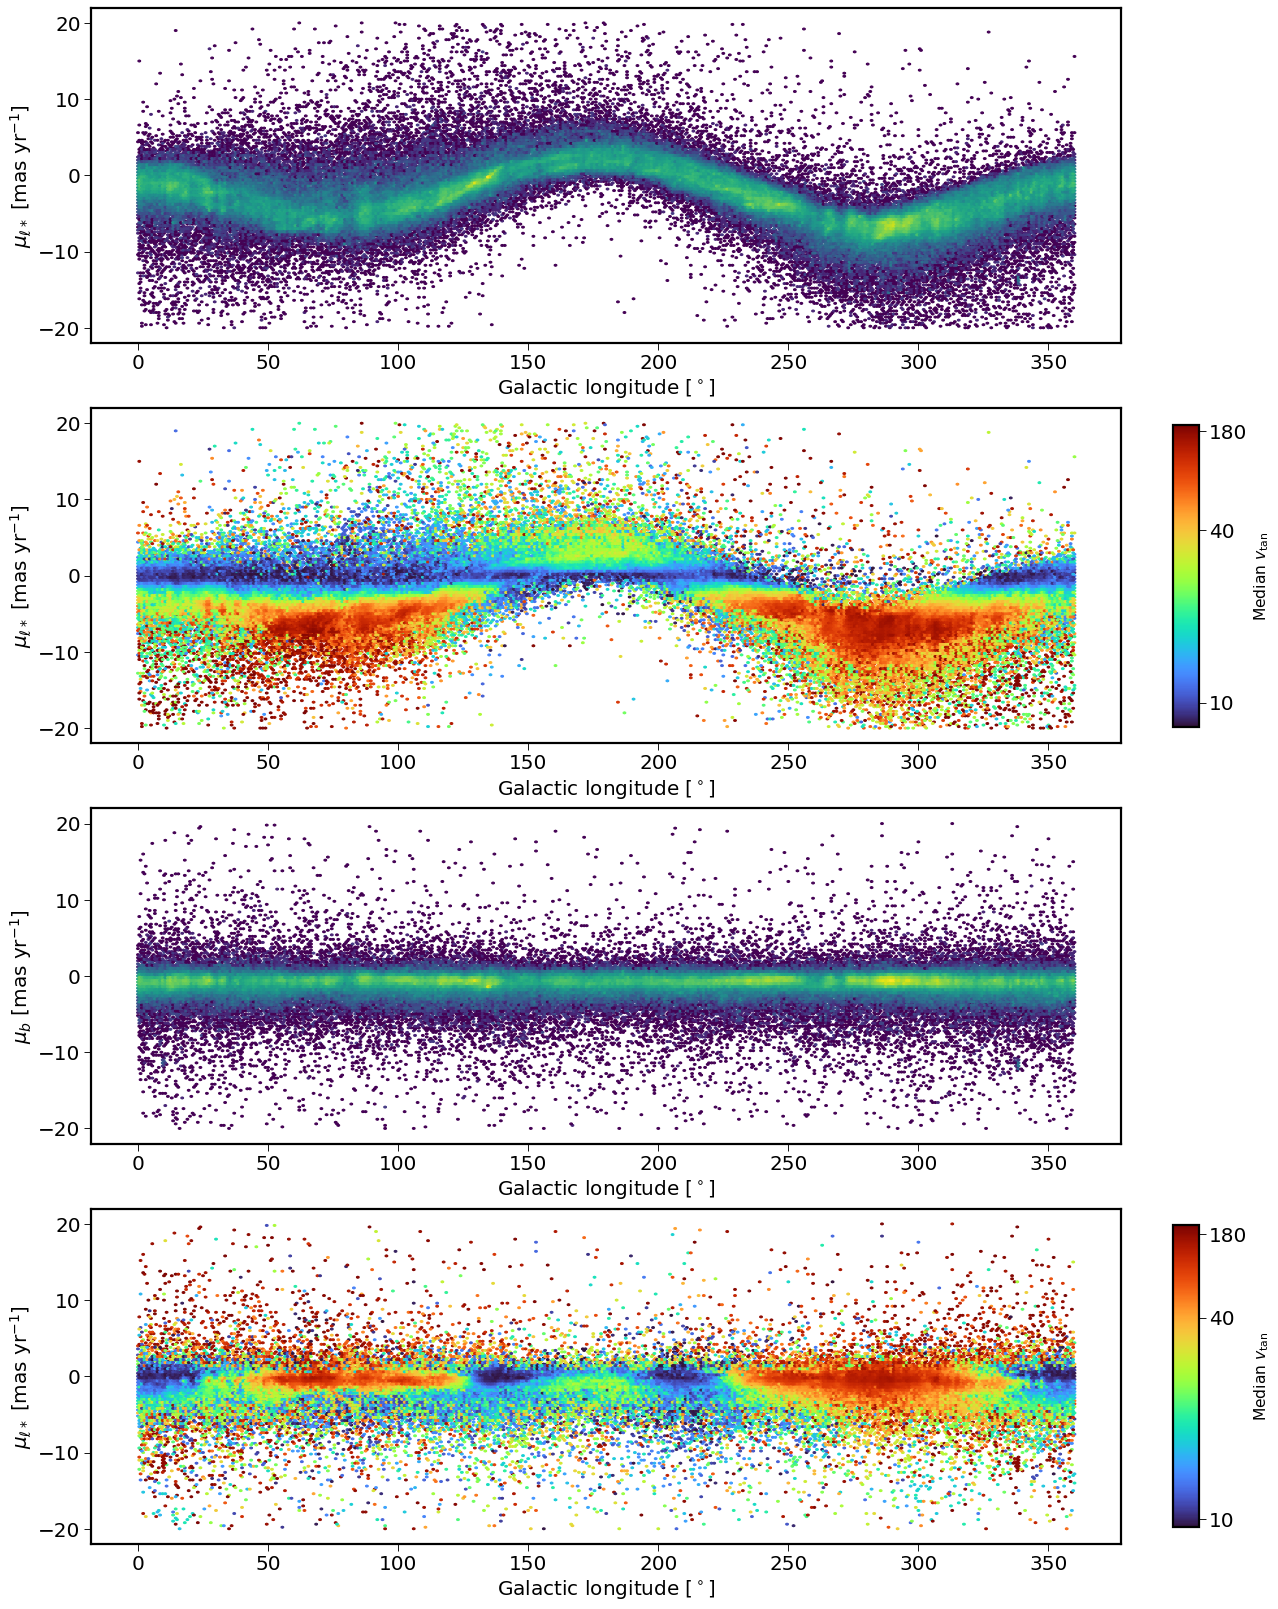

In [16]:
plxsnr_lim = plxsnr_min
plxfilter = obatable['parallax_over_error']>plxsnr_lim
plxfilter_rv = oba_rv['parallax_over_error']>plxsnr_lim
sample_filter = bstars & plxfilter

fig=plt.figure(constrained_layout=True, figsize=(14,20))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')

ccode = 'vtan'
ccode_label = r'Median $v_\mathrm{tan}$'
ax_lmul_vtan = fig.add_subplot(gs[1,0])
im_lmul_vtan = ax_lmul_vtan.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], gridsize=[360,100], extent=[0,360,-20,20],
                             C=obatable[ccode][sample_filter], reduce_C_function=np.median, mincnt=0)
ax_lmul_vtan.clear()
imnorm = ImageNormalize(im_lmul_vtan.get_array(), stretch=HistEqStretch(im_lmul_vtan.get_array()))
im_lmul_vtan = ax_lmul_vtan.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], gridsize=[360,100], extent=[0,360,-20,20],
                             C=obatable[ccode][sample_filter], reduce_C_function=np.median, norm=imnorm, cmap='turbo', mincnt=0)
cax_lmul_vtan = inset_axes(ax_lmul_vtan, "2.5%", "90%", loc='center left', 
                           bbox_to_anchor=(1.05, 0.0, 1, 1),
                           bbox_transform=ax_lmul_vtan.transAxes,
                           borderpad=0)
cbar_lmul_vtan = fig.colorbar(im_lmul_vtan, cax=cax_lmul_vtan, ticks=[10, vtanthin, vtanhalo])
cbar_lmul_vtan.set_label(ccode_label, fontsize=14)
ax_lmul_vtan.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_vtan.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')

ax_lmub_vtan = fig.add_subplot(gs[3,0])
im_lmub_vtan = ax_lmub_vtan.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], gridsize=[360,100], extent=[0,360,-20,20],
                             C=obatable['vtan'][sample_filter], reduce_C_function=np.median, mincnt=0)
ax_lmub_vtan.clear()
imnorm = ImageNormalize(im_lmub_vtan.get_array(), stretch=HistEqStretch(im_lmub_vtan.get_array()))
im_lmub_vtan = ax_lmub_vtan.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], gridsize=[360,100], extent=[0,360,-20,20],
                             C=obatable['vtan'][sample_filter], reduce_C_function=np.median, norm=imnorm, cmap='turbo', mincnt=0)
cax_lmub_vtan = inset_axes(ax_lmub_vtan, "2.5%", "90%", loc='center left', 
                           bbox_to_anchor=(1.05, 0., 1, 1),
                           bbox_transform=ax_lmub_vtan.transAxes,
                           borderpad=0)
cbar_lmub_vtan = fig.colorbar(im_lmub_vtan, cax=cax_lmub_vtan, ticks=[10, vtanthin, vtanhalo])
cbar_lmub_vtan.set_label(r'Median $v_\mathrm{tan}$', fontsize=14)
ax_lmub_vtan.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_vtan.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')

plt.show()

## Spatial distribution

Show the spatial distribution of the OBA stars in the Galactic plane and also indicate (roughly) the effect of the kinematic selection on $v_\mathrm{tan}$ by showing contours of constant $v_\mathrm{tan}$ for the simple kinematic disk model.

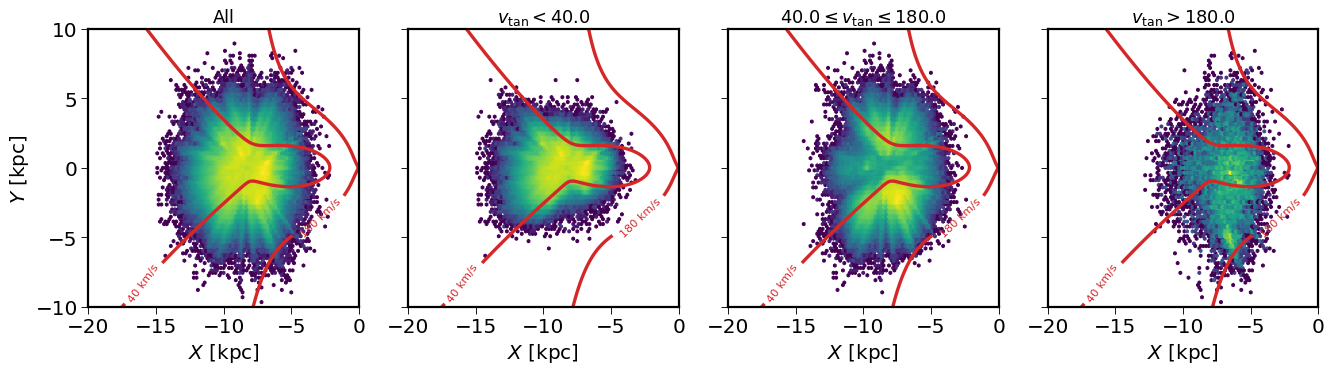

In [18]:
plxsnr_lim = plxsnr_min
if plxsnr_lim>10:
    plotgrid = [-15, 0, -7.5, 7.5]
else:
    plotgrid = [-20,0,-10,10]
    
nx = int(10*(plotgrid[1]-plotgrid[0]))
ny = int(10*(plotgrid[3]-plotgrid[2]))
xdef = np.linspace(plotgrid[0], plotgrid[1], nx)
ydef = np.linspace(plotgrid[2], plotgrid[3], ny)
xx, yy = np.meshgrid(xdef, ydef, indexing='xy') << u.kpc
zz = 0.0*u.kpc
sl = (slice(0,-1,10), slice(0,-1,10))
pml, pmb, vrad, vtan, p, q, r = diskmodel.differential_velocity_field(xx, yy, zz)

plxfilter = obatable['parallax_over_error']>plxsnr_lim

thindisk = obatable['vtan'] < vtanthin
thickdisk = (obatable['vtan'] >= vtanthin) & (obatable['vtan'] <= vtanhalo)
halo = obatable['vtan'] > vtanhalo

fig=plt.figure(figsize=(17,5), tight_layout=True)

gs = fig.add_gridspec(1, 4, figure=fig)
axs =  gs.subplots(sharey=True)
samplefilters = [plxfilter, plxfilter & thindisk, plxfilter & thickdisk, plxfilter & halo]
titles = ['All', rf'$v_\mathrm{{tan}}<{vtanthin}$', rf'${vtanthin}\leq v_\mathrm{{tan}}\leq{vtanhalo}$', rf'$v_\mathrm{{tan}}>{vtanhalo}$']

for ax, filt, paneltitle in zip(axs, samplefilters, titles):
    ax.hexbin(obatable['x_gc'][filt]/1000, obatable['y_gc'][filt]/1000, mincnt=1, bins='log', extent=plotgrid)
    CS = ax.contour(xx, yy, vtan, levels=[vtanthin, vtanhalo], colors='C3')
    ax.clabel(CS, CS.levels, inline=True, fmt="%.0f km/s", fontsize=10)
    ax.set_xlabel(r'$X$ [kpc]')    
    ax.set_title(paneltitle, fontsize=16)
    #ax.label_outer()
    #ax.set_xlim(plotgrid[0:2])
    #ax.set_ylim(plotgrid[2:4])
axs[0].set_ylabel(r'$Y$ [kpc]')

plt.savefig('oba_vtan_selection_bias.png', dpi=150)
    
plt.show()

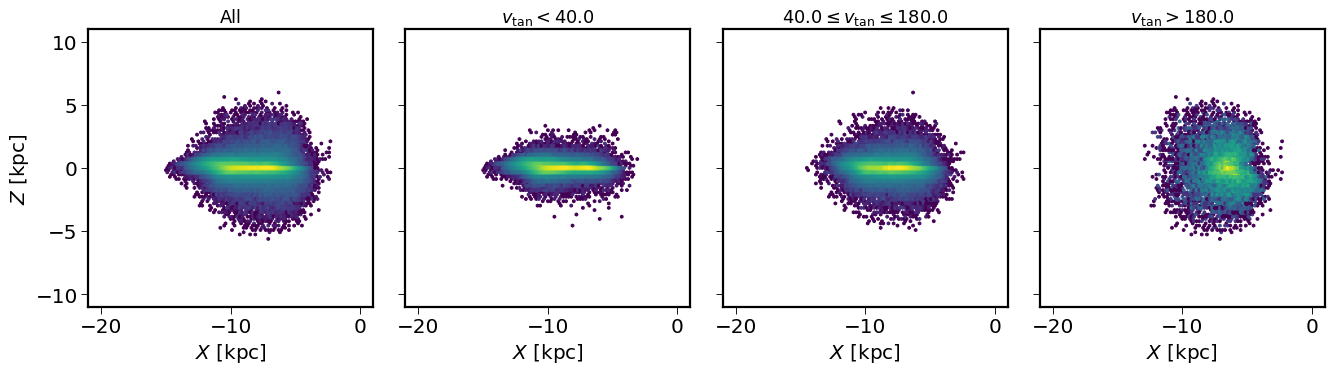

In [19]:
fig=plt.figure(figsize=(17,5), tight_layout=True)

gs = fig.add_gridspec(1, 4, figure=fig)
axs =  gs.subplots(sharey=True)
samplefilters = [plxfilter, plxfilter & thindisk, plxfilter & thickdisk, plxfilter & halo]
titles = ['All', rf'$v_\mathrm{{tan}}<{vtanthin}$', rf'${vtanthin}\leq v_\mathrm{{tan}}\leq{vtanhalo}$', rf'$v_\mathrm{{tan}}>{vtanhalo}$']

for ax, filt, paneltitle in zip(axs, samplefilters, titles):
    ax.hexbin(obatable['x_gc'][filt]/1000, obatable['z_gc'][filt]/1000, mincnt=1, bins='log', extent=plotgrid)
    ax.clabel(CS, CS.levels, inline=True, fmt="%.0f km/s", fontsize=10)
    ax.set_xlabel(r'$X$ [kpc]')    
    ax.set_title(paneltitle, fontsize=16)
    #ax.label_outer()
axs[0].set_ylabel(r'$Z$ [kpc]')
    
plt.show()